# Overview and Goals
![partially folded paper with geometry on it](folded_paper.jpeg)

Our claim is that a live notebook (driving 3rd party tools) provides a wonderful primary interface for some physics simulation workflows and allows the use of tools and approaches familiar to those who work with any other data science.

We will set up a workbench familiar to a Data Science practitioner for working with (large) numbers of CFD datasets indexed by parameters. We will allow these parameters to control the shapes themselves, CFD algorithmic parameters, or hyperparameters for optimization and summary. This involves two favorite DS tools: we will center our work on a Dataframe whose rows represent samples in some design and simulation space, and we will use Jupyter notebooks as the primary interface to the entire design and simulation process. That is, work with creating the geometry, moving the camera around for visualization, and configuring the simulation will be done done in the notebook rather than external tools. This is of course not ideal for many situations: dedicated CAD/CFD/analysis programs are vastly better for doing real work. The hope is that this approach is useful for a certain type of problem and user, and satisies our desire to use a minimal amount of tooling - we can of course swap in richer dedicated tools as needed to improve this generic workflow in specific ways later.

With the ability to view ensembles of physical simulations as classic dataframes, we will do some of the things one normally does with dataframes. We will build models to interpolate and predict, we will use those models to optimize and analyse, and we will explore how to construct the dataframe for a given problem in the most efficient and efficaceous way. 

We can naturally partition this work into three sections, the last of which we will leave for the sequel:

* A Workflow for a Single Simulation
  * Geometry
  * Meshing
  * Simulation
  * analysis
* Dataframe centered Simulation Ensembles
  * Dataframe schema
  * Input -> Output multimappings
  * ( Larger frames -> Spark)
* CFD Ensemble Centered Applications
  * Surrogate Models (estimation)
  * AeroDBs (precomputed ensmebles)
  * Optimization

### Audience

This article is likely most useful for two types of reader:  
* comfortable with data science tools with a basic knowledge or interest in physics simulation
* physics simulation practitioners wanting to use common datascience tools in their work. 

We will treat the actual simulation as something of a "black box": to us a given simulation run is just one mapping from the input space to the output space among many. Making this simulation achieve an optimal balance between cost and accuracy (of various sorts) is of course a deep area of expertise, involves problem specific understanding, and is beyond our scope here.

### Problem Space

This is intended for cases which may be naturally indexed by some reasonable number - say 1 to 100 - of parameters - these will be the "input sample" columns in our data frame. One fully populated row of these parameters should be a neccessary and sufficient condition to run and analyze a single simulation. Note however that the dataframe centered approach we take lends itself naturally to 


We will start with non-transient problems, but this is only for initial simplicity.

### Solution Space
The outputs should be available for any completed simulation (row of the DF), and will be the "output columns" of our dataframe.  Note that this can and should include not only physical metrics (like lift and drag) but computational ones (like run time or stability).

Readers hailing from the systems/datascience side will note that we use the shell and file interfaces in some places a cleaner direct API could be used. This is intentional, but not a requirement. It's useful because a number of simulation tools tend to take this configuration file approach and because it makes it's easier to, for example, pull a directory of image files into a movie with `ffmpeg` than to sort out a live interface for doing so. It also makes it easy to decouple components - we try to use light interfaces, so switching CFD engines or visualization should be mostly independent of the high level workflow. It is certainly possible to use direct API when it makes sense, as we do for interacting with constructive solid geometry for example.


## Approach

We set up a tool chain of everything required to take an input row and generate an output row, from parametric CAD and meshing through CFD simulation, analysis, and aggregation. We begin using Open Source tools anyone can run on a personal computer, then later explore more aggressive (and non-free in all senses) environments.

### Workbench - which tools will we use?

The tools for this articleare as few and as free as possible. However, we try to keep the tool-specific details as easily changed as possible - later articles will explore more complex cases, tools that are more focused and not free, and larger scale parallel computation, so we want to make that easy down the road.

Fundamentally, we work with Python Notebooks as a way to elegantly tie together multiple tools and platforms into coherent workflow, orchestrate computation, and analyze results.


#### Dataframes and ML
We want to have a familiar way to work with arrays of data and tools for processing them.

A primary goal here is to treat the exploration of a design space as simply mapping problem parameters to objective functions. That is, we'd like to take some geometry and simulation configuration values (input vector) and map them to some estimated physical/computational results (output vector). Note that this is classic Data Science, and so we'd like to keep a DataFrame (Pandas, for now) at the center of our work.

#### Geometry and Model
We use `gmsh` for both Parametric CAD and our Meshing. The python interface makes this pleasant-ish We will explore varying geometric parameters by rebuilding geometries and then meshes for different values. We will generate `gmsh` output files as well as....

#### Mesh

#### CFD

We use SU2.

#### Analysis
We will aggregate the tabular outputs from SU2 and process them using Pandas, Numpy, and other common DS tools.

#### Optimization

Given a fully populated DOEFrame fit a simple model and optimize that.

In [1]:
# Get notebook dir on path
import pathlib, sys
sys.path.append(pathlib.Path().absolute())

# general tooling
import subprocess, sys,os, shutil, math, types
import pandas
import numpy as np
from itertools import chain

# general datascience tooling:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from IPython.display import Image, HTML
from mpl_toolkits.mplot3d import Axes3D

# CFD Specific interfacaces & utilities:
import lightningcatcher_gmsh as geometry
import lightningcatcher_su2 as cfd
import lightningcatcher_paraview as vis


# A CFD Workflow for a Single Simulation

We begin by setting up the tools and models to run a single standalone simulation and analyze its results.

### A simple parameterized geometry problem
We will use  a very simple parametrized geometry model to expore a design space and provide a common example across a number of projects: a standard paper airplanem as descibed [in Wikipedia](https://en.wikipedia.org/wiki/Paper_plane).

We can also cheat a little and compare ourselves against analytical and ground truth results using [existing work](http://www.lactea.ufpr.br/wp-content/uploads/2018/08/On_the_Aerodynamics_of_Paper_Airplanes.pdf)

This design starts with a $\pi/4$ and $\pi/8$ fold we can't change, but at the end has a nice design parameter we can vary. The angle of the final fold of the wings out to each side of the fuselage provides a design parameter which is simple yet interesting from both an aerodynamic and optimization perspective. That is, what we have annotated as $\phi$ on this  diagram:

![Wikipedia-sourced Plane Param](plane_param_diagram.jpg)

There are many others we can explore, but we will limit ourselves to this and a single enivonmental variable: the angle of attack. We'll use this first example as a use case for our tools for creating the Geometry through analyzing CFD output. 

## Geometry
### parameterized paper airplanes

Let's begin with the constructive geometry build for the geometry itself. We'll go into most of this in another notebook (here, if you're interested), for now we're just going to set some of the parameters we'll care about, and make sure we can generate a 3D model file for our plane. Note that we will for now generate a separate model file for each value of any design parameters, rather than encoding the parameter into the CAD outpput so it can be modified directly. This has an additional benefit in that it decouples the geometry, meshing, and simulation stages, allowing more flexibility with which tools are used. Obviously, some neat things are possible if these stages are communicating: simulation results may help improve our meshing, for example. But for now, we will stick with the large design loop from geometric parameters (Phi and Theta, or "fuselage_rads" and "angle_of_attack") though simple physical outputs - namely Drag and Lift.

For now, we just want to take a single example conf from geometry through analysis. We begin instantiating and visualizing the geometry, using `gmsh` for both. Our design space includes a lot of things we likely won't vary: the size of the paper, the final "camber" angle of the wings, etc. We encode them all in a dict, with some algorithm and visualization parameters too for convenience. You will not be misled if you think of this as a row in a dataframe, or the input point in a smaple space, but we won't do so here just yet.

For now, we'll use a single config for geometric, algorithmic, and visualization parameters:

In [2]:
no_display=False
config = {
    # Get rid of:
    "meshsize_large": 5.0,           # uniform meshing for now
    "meshsize_small": 0.8,  
    "case_index": 0,  
    "base_dir": "/Users/scot/Projects/Personal/lightningcatcher/notebooks/",
    "sim_path": "/Users/scot/Projects/SU2/bin/SU2_CFD",
    "mesh_resolution": 0.2,
    "mesh_sizemin_scale": 5.0,
    "mesh_sizemax_scale": 25.0,
    "mesh_distmin_scale": 10.0,
    "mesh_distmax_scale": 50.0,
    "group_boundary_size": 6.0,
    "bounding_box_size": 15.0,    
    "full_fold_radians" : geometry.pi,     # usually pi, unless we fold loosely
    "wing_tilt_radians" : geometry.pi/2.0,  # wing angle with fuselage
    "camZoom":5.0,
    "camOffsetX":0.0,
    "camOffsetY":0.0,
    "case_name": f"case",      # overall project name (directory)
    "paper_size_x" : 11.0,                 # sheet of paper height
    "paper_size_z": 4.25,                  # paper width
    "paper_thickness":0.1, 
    "body_tilt_radians" : geometry.pi/8.0,  # main fuselage fold angle
    "camX":30.0,                     # Camera positioning
    "camY":60.0,
    "camZ":0.0,
    "camOffsetZ":0.0,  
    'project_name': "abc1",
    "mach_number": 0.01,
    "fuselage_radians" : 0.6, #geometry.pi/8.0,   # wing "slope" fold angle
    "angle_of_attack" : 12.0,        # orientation to wind/movement
}

To construct our model for a given parameter set we need only a "sheet" to start, a "fold" operation, and a "mirror" operation to save some time at the end. These should all be elementary operations in any geometry package, with a few cross products from `numpy`. We'll keep the impementation separate to make it easy to use different packages - using `gmsh` here.

In [3]:
# We'll make this a function - for easy variable access to config values, but also for later work
def make_airplane_model(**config):
    
    # initialize the project, set camera view, and create the sheet of paper:
    c = types.SimpleNamespace(**config)
    geometry.initialize() #case_name)
    geometry.set_camera(c.camX, c.camY, 
                        c.camZ, c.camZoom, c.camZoom, c.camZoom,
                        c.camOffsetX, c.camOffsetY, c.camOffsetZ)
    sheet=geometry.make_sheet(p1,p2,p3,p4, c.paper_thickness)
    
    # define points & angles from the above diagram, starting with corners of the paper
    p1,p2,p3,p4 = ( [0.0, 0.0, 0.0],
                    [0.0, 0.0, c.paper_size_z],
                    [c.paper_size_x, 0.0,  c.paper_size_z],
                    [c.paper_size_x, 0.0, 0.0])
    fold_val = c.paper_size_x*math.tan(geometry.pi/8.0)
    fixed_intercept = [c.paper_size_x, 0.0, fold_val] # c.paper_size_x*math.sin(gmsh.pi/8.0), 0.0]
    intercept = [c.paper_size_x, 0.0, c.paper_size_z*math.sin(c.fuselage_radians)]
    origin = [0.0, 0.0, 0.0]
    first_fold_pojnt = [c.paper_size_z, 0.0,c.paper_size_z]
    
    # fold the sheet into the airplane:
    # two folds from the nose, then the final fold forms the wing
    fold1 = geometry.fold(sheet, origin, first_fold_pojnt, p2,c.full_fold_radians)
    fold2 = geometry.fold(fold1, origin,fixed_intercept, p2, c.full_fold_radians)  
    half = geometry.fold(fold2, origin,intercept,p2, c.wing_tilt_radians)
    
    # tilt a little for the "v" of the fusesage, then mirror.
    rhalf = geometry.fold(half, origin,p4, p2, c.body_tilt_radians)
    lhalf = geometry.copy(rhalf)
    geometry.mirror(lhalf, 0, 1,0, 0)
    
    # merge all the parts of the shape, remove internal surfaces, return model:
    geometry.synchronize()
    thing, lhb = geometry.fuse(rhalf, lhalf)
    return thing

We can take a look at our model before proceeding, just using `gmsh` itself. This is a nice way to dial in our model before proceeding, since we can change any of the parameters easily when we call it. 

Let's try it out!

In [ ]:
# camera_params=dict(camX=-5.0,camY=30.0,camZ=10.0,camZoom=2.0, camOffsetX=-0.0)
examples = []
example_geometries = [geometry.pi/x for x in [22.0, 8.0, 4.0] ]
for i in range(3):
    examples.append(cfd.single_simulation(config, make_airplane_model, do_meshing=False, run_simulation=False, 
                                         **dict(camX=-60.0,camY=0.0,camZ=-30.0,camZoom=1.5, camOffsetX=-0.0, meshsize_large=3.0,
                                               fuselage_radians=example_geometries[i], define_surface_groups=False,
                                               case_name=f"{config['project_name']}-{i:0>3}")))
    # print(f"{i} -> {examples[i]['imagepath']}")

# This is just a handy shortcut to make an HTML view of these, either for markdown later or Jupyter now:

In [70]:
#captions = [f"Fuselage Angle: {e['fuselage_radians']:.2f} rad" for e in examples]
#images =   [e['imagepath'] for e in examples]
imgtable = lambda captions, images: "<table><tr><td>" + "</td><td>".join( captions) + \
    "</td></tr><TR><td>" + \
    "</td><td>".join( [f"<img src=\'{img}\'>" for img in images] ) + \
    "</td></tr></table>"
html_hack = lambda examples: imtable([f"Fuselage Angle: {e['fuselage_radians']:.2f} rad" 
                                      for e in examples],[e['imagepath'] for e in examples])

display(HTML(html_hack(examples)))

That looks good enough for now. Note we're leaving the paper unrealistically thick here. For now though, let's sprint to trying to get some aero modelling done!

## simple meshing

We do the most simplistic of meshing here, for simplicity. Note this is a terrible idea from an accuracy perspective! However, it keeps the geometry very simple and leaves us a great example of using this approach to improve our models in a later article. Since we're not tuning anything, we just need to tell it to do the meshing:

In [56]:
c2 = cfd.single_simulation(config, make_airplane_model, run_simulation=False, interactive=False,
                       **dict(camX=-52,camY=38.8,camZ=0.0,camZoom=2.5, camOffsetX=-0.0))

print(c2['imagepath'])
# display(Image(filename=c2['imagepath']) )

adding Group 1 'Plane': [[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]]
res: 1
adding Group 2 'Walls': [[1, 2, 3, 4, 5, 6]]
res: 2
abc1/case.jpg


![foo](abc1/case.jpg)

##  Simple Simulation
### 3D flow in air at low velocity

In [7]:
c3 = cfd.single_simulation(config, make_airplane_model,
                           do_extract=['eff_coeff','lift_coeff', 'drag_coeff', 'momentum_z', 'momentum_x'],
                           stdout_to_log=True,
                           **dict(camX=-5.0,camY=60.0,camZ=10.0,camZoom=3.0, camOffsetX=-0.0))

adding Group 1 'Plane': [[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]]
res: 1
adding Group 2 'Walls': [[1, 2, 3, 4, 5, 6]]
res: 2



## Analysis of a single simulation run

We ran our single simulation, but don't have much to look at yet. Let's look into how we can take a look at our results - numerically and visually.

#### Extract per-surface and global objective function values

Note that we update the increasingly poorly named "conig" for each simulation with resultant output variables, so we have some output global data already available to us. We'll look at the Aerodynamic Efficiency as a way to quantify "how good" a given design is:

$$ \mathit{Aero\ efficiency} = \frac{\mathit{Lift}}{\mathit{Drag}} = \frac{\mathit{Lift\ Coefficient}}{\mathit{Drag\ Coefficient}}$$

In [55]:
c3['lift_coeff']/c3['drag_coeff'], c3['eff_coeff']

(2.16778033380071, 2.167780334)

#### Visualize single flow in `matplotlib`

To verify we're getting the point data we think for output functions like `lift` and to show a first step toward building our own visualizations using `matplotlib` and standard DS tools, let's open up the surface flow CSV file we generate for each sim and extract global physics data from:

Using standard notebook 3D plotting can get us started visualizing the results of our simulation. Let's make a 3D scatter of our airplane model with the estimated force vector at each point. In `base.cfg` we set the output path for a surface flow file. So, we can just read that:


<IPython.core.display.Javascript object>


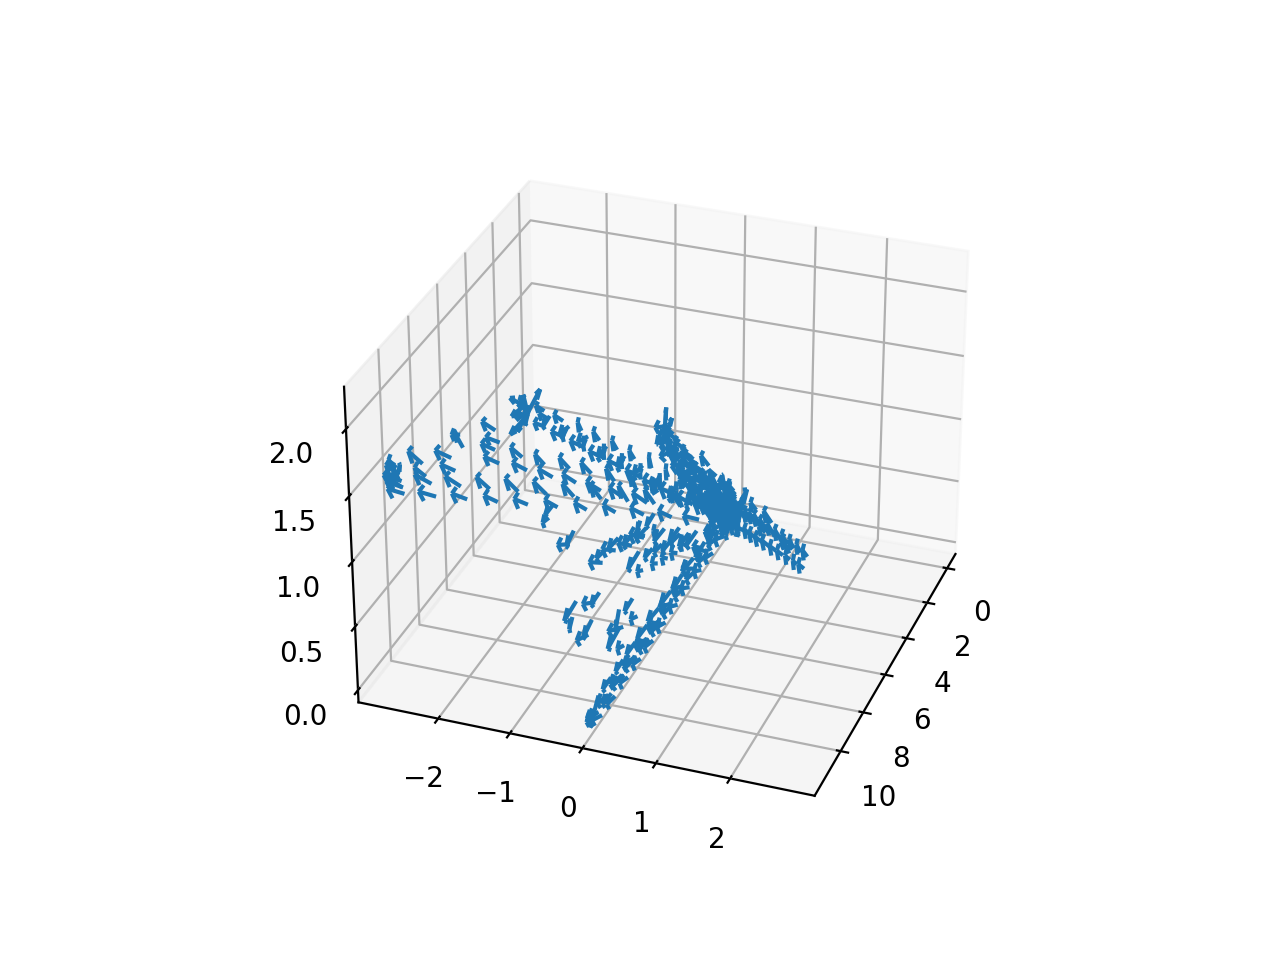

In [46]:
sdf=pandas.read_csv( os.path.join(config['project_name'], 'case-surface_flow.csv'))
fig2 = plt.figure()
ax21 = fig2.add_subplot(projection='3d', azim=20)
ax21.quiver(sdf['x'], sdf['y'],sdf['z'], sdf['Momentum_x'], sdf['Momentum_y'], sdf['Momentum_z'])
#fig2.show()
plt.savefig("abc1/quiver.jpg")

#### Visualize flow solution using external vis package
For more involved simulation we'll use a purpose built tool. Let's generate a single vis frame for one of our sample space simulations:

In [113]:


c3['viz_path'] = vis.visualize_case(c3['project_name'], c3)

#display(Image(filename=c3['viz_path'] ))
print(c3['viz_path'])

para-processing abc1/case...


(   1.882s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7f920d7e9a10): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.139s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f91dd884d10): Could not determine array range.
(   2.139s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f91dd884d10): Could not determine array range.


abc1/case-para.png


#  Dataframes for CFD Ensembles

Often we're concerned with a set of related simulation runs. How should we consider this element and set? A Data Science person might like to consider a single simulation as a row in a dataframe; a CFD practitioner might think of it as an element of a DOE; a designer may just have a bunch of experimenal runs to compare and relate.

It's nice sometimes to think of CFD simulation runs as simply another mapping from an input space to an output space. We may have multiple ways to construct this mapping - for instance: different algorithmic parameters and entire algorithms, precise vs fast CFD and even non-CFD estimates, even experimental data. So rows in the input space will not have unique images in the output space unless we include the mapping used as an input. It can be useful to seperate physical inputs (air temperature), design inputs (fuselage angle), model inputs (mesh size), and algorithmic ones (CFD, linear solver), but here we want to keep things as simple as possible so we'll keep all the inputs "flat" for now.

Each row of our dataframe will contain everything needed to run and analyze a single simulation - a sample from our input space. There may be template files and mesh files which are not part of the dataframe, generally platform specific, but everything needed to generate and use these files will be columns in our dataframe.



We want a dataframe with the input part of every row populated with interesting values. Then for a given mapping we can generate the outputs. We begin by specifying all the static parameters and then varying a subset - the DOE parameters, or a sampling method in the input space, or a set of values of interest. In this case, we will vary the `fuselage_rad` alone - then with `angle of attack` in a simple grid:

We'll uses a  function to add columns to the dataframe for our project, which can involve any of:
* run CFD simulation
* extract values from previously run simulation
* apply estimations (surrogate models) to generate values
* generate sumary and visualization data

So, the return value will be available as a dataframe row.

## Build the dataframe
### First create the rows from sample points:

In [13]:
df = pandas.DataFrame(
    [dict(chain(
            config.items(),
            {
                "case_name": f"{config['project_name']}-{5*i+j:0>3}",
                "fuselage_radians" : 0.15 + 0.02*i,
                "angle_of_attack" : 0.0 + 3.0 * j,
             }.items())) 
     for i in range(5) for j in range(5)])

### Next run simulations and add columns for extracted output
Now we'll add actual models, config, and simulation results to each row. Here we do it all at once with a the helper function mentioned above.

In [14]:
df = pandas.DataFrame(
    [cfd.single_simulation(
        row, make_airplane_model,
        do_extract=['eff_coeff','lift_coeff', 'drag_coeff', 'momentum_z', 'momentum_x'],
        stdout_to_log=True) 
     for row in df.to_dict(orient='records')])

df['aoa_rads'] = df.apply(lambda r:  np.deg2rad(r['angle_of_attack']), axis=1)

adding Group 1 'Plane': [[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]]
res: 1
adding Group 2 'Walls': [[1, 2, 3, 4, 5, 6]]
res: 2
adding Group 1 'Plane': [[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]]
res: 1
adding Group 2 'Walls': [[1, 2, 3, 4, 5, 6]]
res: 2
adding Group 1 'Plane': [[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]]
res: 1
adding Group 2 'Walls': [[1, 2, 3, 4, 5, 6]]
res: 2
adding Group 1 'Plane': [[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 

So we can do the usual things to explore this space. As a two-dimensional response surface, we can plot this as something like a "carpet plot" with our two parameters against Lift (plotted as height) and Drag (plotted as color).

<IPython.core.display.Javascript object>


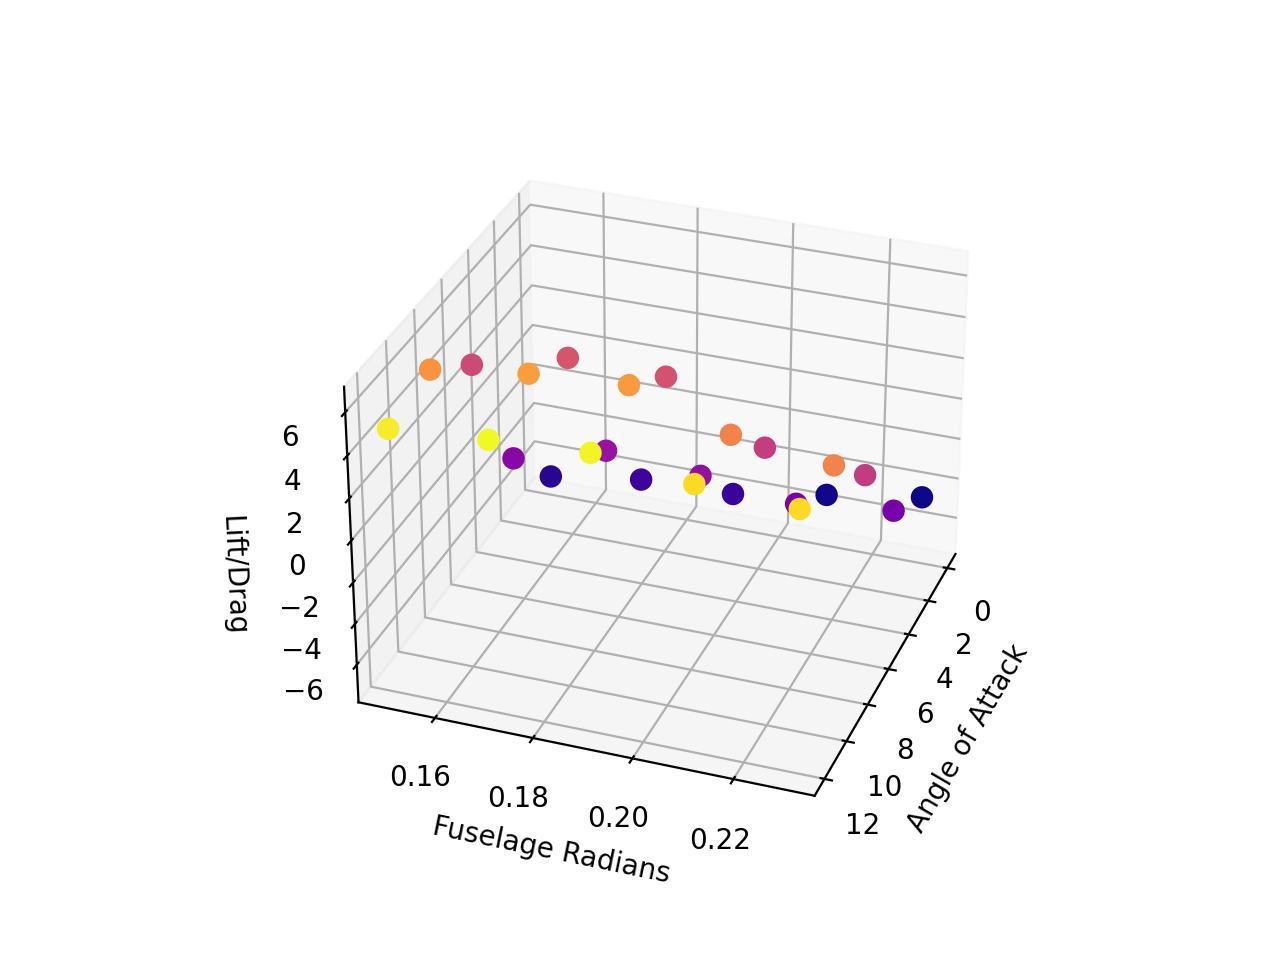

In [57]:
%matplotlib notebook
fig2 = plt.figure()
ax21 = fig2.add_subplot(projection='3d', azim=20)
ax21.scatter3D(df['angle_of_attack'], df['fuselage_radians'],df['eff_coeff'], 
               s=50, alpha=1.0, c=df['lift_coeff'],
               cmap='plasma')
ax21.set_xlabel('Angle of Attack')
ax21.set_ylabel('Fuselage Radians')
ax21.set_zlabel('Lift/Drag')
plt.savefig("simple_3d_scatter.png")

## More visualization

### Flow visualization for each sample point

Add visualization images to each case using an external Visualization tool:

In [114]:
df['vispath'] = df.apply(lambda row: vis.visualize_case(row['project_name'], row), axis=1)

para-processing abc1/abc1-000...


(   1.855s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fbcc681c460): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.101s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fbc7603b450): Could not determine array range.
(   2.101s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fbc7603b450): Could not determine array range.


para-processing abc1/abc1-001...


(   1.787s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7f7af39513f0): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.020s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f7af2fa7840): Could not determine array range.
(   2.020s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f7af2fa7840): Could not determine array range.


para-processing abc1/abc1-002...


(   1.808s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7f9c4379ebb0): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.014s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f9c437fc2a0): Could not determine array range.
(   2.014s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f9c437fc2a0): Could not determine array range.


para-processing abc1/abc1-003...


(   1.852s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7f8ff908cff0): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.085s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f8fd8fa94f0): Could not determine array range.
(   2.085s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f8fd8fa94f0): Could not determine array range.


para-processing abc1/abc1-004...


(   1.756s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7f9a8af0fe10): Refusing to enable OSPRay because it is not supported running in this configuration.
(   1.986s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f9a8afd8550): Could not determine array range.
(   1.986s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f9a8afd8550): Could not determine array range.


para-processing abc1/abc1-005...


(   1.780s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fedb3f1e5e0): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.004s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fedb4559050): Could not determine array range.
(   2.004s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fedb4559050): Could not determine array range.


para-processing abc1/abc1-006...


(   1.771s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fe6e1f5bd60): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.009s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fe6e2642440): Could not determine array range.
(   2.009s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fe6e2642440): Could not determine array range.


para-processing abc1/abc1-007...


(   1.759s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7f8054f95670): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.010s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f8054f7af10): Could not determine array range.
(   2.010s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f8054f7af10): Could not determine array range.


para-processing abc1/abc1-008...


(   1.792s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fb810f87780): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.037s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fb810f6d8a0): Could not determine array range.
(   2.037s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fb810f6d8a0): Could not determine array range.


para-processing abc1/abc1-009...


(   1.771s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fdfecfe9f90): Refusing to enable OSPRay because it is not supported running in this configuration.
(   1.997s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fdfacf479f0): Could not determine array range.
(   1.997s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fdfacf479f0): Could not determine array range.


para-processing abc1/abc1-010...


(   1.825s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fefc40fd310): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.063s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fefc40e2770): Could not determine array range.
(   2.063s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fefc40e2770): Could not determine array range.


para-processing abc1/abc1-011...


(   1.794s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7f899574ba00): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.034s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f89f6084300): Could not determine array range.
(   2.034s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f89f6084300): Could not determine array range.


para-processing abc1/abc1-012...


(   1.784s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7f7bd48a0160): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.028s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f7be5893520): Could not determine array range.
(   2.028s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f7be5893520): Could not determine array range.


para-processing abc1/abc1-013...


(   1.767s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fecb00114f0): Refusing to enable OSPRay because it is not supported running in this configuration.
(   1.988s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fec7730c4b0): Could not determine array range.
(   1.988s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fec7730c4b0): Could not determine array range.


para-processing abc1/abc1-014...


(   1.775s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fee76fdff60): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.006s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fee97906f80): Could not determine array range.
(   2.006s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fee97906f80): Could not determine array range.


para-processing abc1/abc1-015...


(   1.757s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fda602519b0): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.001s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fda3049c2f0): Could not determine array range.
(   2.001s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fda3049c2f0): Could not determine array range.


para-processing abc1/abc1-016...


(   1.767s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fe605fdc5d0): Refusing to enable OSPRay because it is not supported running in this configuration.
(   1.992s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fe5b6646350): Could not determine array range.
(   1.992s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fe5b6646350): Could not determine array range.
(   2.071s) [paraview        ]    vtkStreamTracer.cxx:1673   ERR| vtkPStreamTracer (0x7fe5b71c4a20): Bad velocity array.


para-processing abc1/abc1-017...


(   1.765s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7f7a7f79e330): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.012s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f7a7f7dcaa0): Could not determine array range.
(   2.012s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f7a7f7dcaa0): Could not determine array range.


para-processing abc1/abc1-018...


(   1.791s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fc0b8795220): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.026s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fc0a98065c0): Could not determine array range.
(   2.026s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fc0a98065c0): Could not determine array range.
(   2.101s) [paraview        ]    vtkStreamTracer.cxx:1673   ERR| vtkPStreamTracer (0x7fc068a28f00): Bad velocity array.


para-processing abc1/abc1-019...


(   1.761s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7f9179f963f0): Refusing to enable OSPRay because it is not supported running in this configuration.
(   1.994s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f9179ff19a0): Could not determine array range.
(   1.994s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f9179ff19a0): Could not determine array range.


para-processing abc1/abc1-020...


(   1.783s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fbebdf1ed00): Refusing to enable OSPRay because it is not supported running in this configuration.
(   1.990s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fbe9e427580): Could not determine array range.
(   1.990s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fbe9e427580): Could not determine array range.


para-processing abc1/abc1-021...


(   1.771s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7ff06273b220): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.007s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7ff082820150): Could not determine array range.
(   2.007s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7ff082820150): Could not determine array range.


para-processing abc1/abc1-022...


(   1.787s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fe2d579d6b0): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.022s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fe2e57e1cf0): Could not determine array range.
(   2.022s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fe2e57e1cf0): Could not determine array range.


para-processing abc1/abc1-023...


(   1.770s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fb16bf2ce00): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.003s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fb15c3685b0): Could not determine array range.
(   2.003s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fb15c3685b0): Could not determine array range.


para-processing abc1/abc1-024...


(   1.785s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fc94dfb7480): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.017s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fc90e634300): Could not determine array range.
(   2.017s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fc90e634300): Could not determine array range.


In [120]:
df[['fuselage_radians','angle_of_attack']]

,fuselage_radians,angle_of_attack
0,0.15,0.0
1,0.15,3.0
2,0.15,6.0
3,0.15,9.0
4,0.15,12.0
5,0.17,0.0
6,0.17,3.0
7,0.17,6.0
8,0.17,9.0
9,0.17,12.0


In [122]:
#imgtable(["one", "twelve", "22"],
#          [df.iloc[1]['vispath'], 
#           df.iloc[12]['vispath'], 
#           df.iloc[22]['vispath']])
display(HTML(imgtable(["two", "twelve", "22"],[df.iloc[2]['vispath'], df.iloc[12]['vispath'], df.iloc[22]['vispath']])))

two,twelve,22,,,


### Simple animation across cases

In [ ]:
def animate(project_name, file_paths, output_dir, framerate="2"):
    ffmpeg_path='/Users/scot/bin/ffmpeg'
    base_dir=config['base_dir']
    for i,file_path in enumerate(file_paths):
        shutil.copyfile(os.path.join(base_dir,file_path), os.path.join(base_dir, output_dir, f"animation_frame-{i:0>3}.png"))
    subprocess.run([ffmpeg_path, "-r", framerate,  "-y", "-i", 
                    f"{config['base_dir']}/{project_name}/animation_frame-%03d.png", 
                    f"{config['base_dir']}/{project_name}/{project_name}.gif"]) 
    #for i,file_path in enumerate(file_paths):
    #    os.remove(os.path.join(output_dir, f"animation_frame_{i}.png"))
    return f"/Users/scot/Projects/{project_name}/{project_name}.gif"

In [ ]:
# animate('aaa', [f"aaa/aaa-0{i}-para.png" for i in [10,11,12,13,14]], 'aaa')#

### Persist Dataframe
We will return to this design space and problem in the "Application" sequel to this article, so it's nice to note that we can store the dataframe for direct manipulation, and it includes everything we'll need if we want to run more simulations later.

In [20]:
df2.to_csv(f"{config['project_name']}/{config['project_name']}_df.csv")
#df2 = pandas.read_csv(f"{config['project_name']}/{config['project_name']}_df.csv")

Now that we can see the general response surface, it would make sense to delve into how to run our simulation enemble more efficiently. We might use "Total Run Time" or something like convergence to generate a response surface while we vary things like mesh size or other alogorithmic parameters. We also can see it would be interesting to explore a larger patch of the `(AoA, FuselageAngle)` space. 

That means we're at a good point to end this notebook - we are exploring properties of the space using dataframes in a notebook in a way that faciliates ensemble thinking. In later notebooks, we'll look at using this ability for a range of applications and modelling improvements.


# Open Questions and Next Steps

* Try running the `single_simulation` examples above with `interactive=True`. This will bring up `gmsh` or `paraview` (resp.) to let you move around camera angles and play with parameters, and is a wonderful exploratory mode to work in.
* What is going on with the dip in aerodynamic efficacy as the wing goes just past the exact edge of the fuselage (at $pi/32$). The sharp dip suggests something interesting - very likely, a bug in our geometry code; most likely, the naively simple simulation approach creating unphysical behaviors; or least likely, an actual critical point of some kind in the physics. 
* Should the angle of attack be normalized to the fold angle, so the wing is always at $0^{\circ}$?

# Applications

## Surrogate Models

## Simple surrogate modeling

To wrap up our example of using this dataframe centered approach to exploring a CFD design space, let's make a simple Surrogate model for our simulation and compare the resulting response surface to the actual CFD data.

<IPython.core.display.Javascript object>


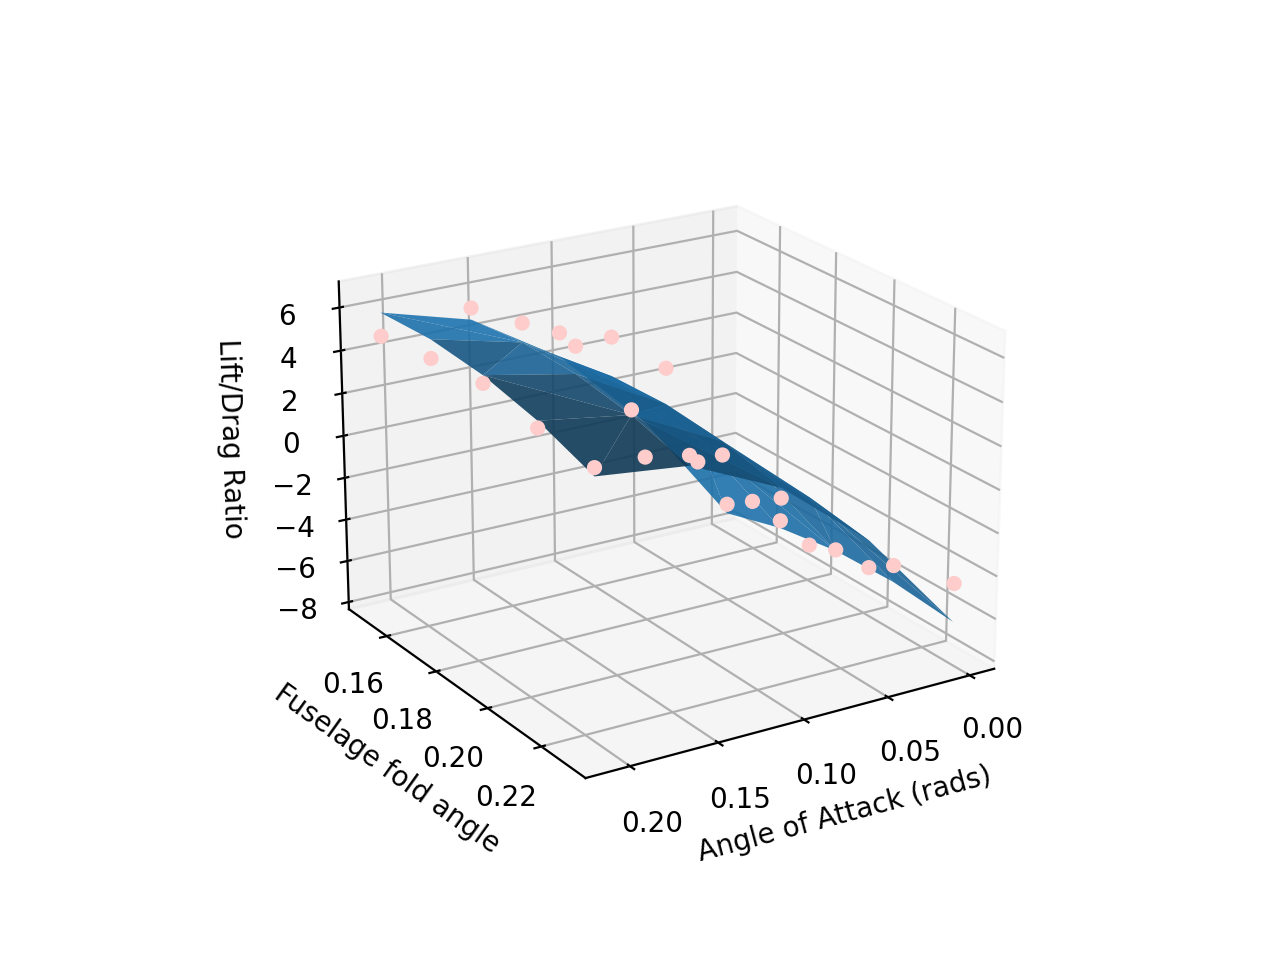

In [78]:
%matplotlib notebook
# build the transform to order-2 polynomials and fit a linear model there:
poly = PolynomialFeatures(2)
pt=poly.fit(df[['angle_of_attack', 'fuselage_radians']])
poly_model = LinearRegression()
poly_model.fit(pt.transform(df[['angle_of_attack', 'fuselage_radians']]), df['eff_coeff'])

# Plot the CFD values against the fit model:
fig2 = plt.figure()
ax21 = fig2.add_subplot(projection='3d', azim=20)
ax21.plot_trisurf(df['aoa_rads'], df['fuselage_radians'],
                poly_model.predict(
                    pt.transform(df[['angle_of_attack', 'fuselage_radians']])),alpha=0.90)
ax21.scatter3D(df['aoa_rads'], df['fuselage_radians'],df['eff_coeff'] , 
               s=20, alpha=1.0, 
               c='#FCC')

# Label and Legend
ax21.set_xlabel("Angle of Attack (rads)")
ax21.set_ylabel("Fuselage fold angle")
ax21.set_zlabel("Lift/Drag Ratio")
fig2.show()
fig2.savefig('carpet_plot.png')

## AeroDB

### Simple

### Large/Dist'd DFs

### Use as lookup table for Realtime Flight Simulation

At this point, we have a dataframe with all the parameters and simulation outputs as rows. 
Let's add a Angle of Attack in Radians to make it easier to relate to our fold.
Here we pull some interesting values out for a specific value of our Angle of Attack by way of example:

In [15]:
df[df.angle_of_attack==6][['angle_of_attack', 'aoa_rads', 'fuselage_radians', 'eff_coeff','case_name']]\
    .sort_values(by=['fuselage_radians'])


,angle_of_attack,aoa_rads,fuselage_radians,eff_coeff,case_name
2,6.0,0.10472,0.15,3.300982,abc1-002
7,6.0,0.10472,0.17,4.439118,abc1-007
12,6.0,0.10472,0.19,4.356859,abc1-012
17,6.0,0.10472,0.21,1.817577,abc1-017
22,6.0,0.10472,0.23,1.363224,abc1-022


## simulation optimization

### variable mesh size and granularity

### other algorithmic parameters

### 

## design optimization

What is an interesting AoA to optimize along?

What are useful physical parameters?

Do our result make physical sense?

How should we define fitness?

How should we optimize fitness with our single variable?

Dakota Project

# Add more data and Answer the Question. 

Rule 1: For now.

This is all fun, but we haven't answered our question. How should we make that last fold on a "dart" style paper airplane?

What does that even mean. The optimal fold will be corellated with the throw angle (angle of attack) since the angle of the wing means that if thrown parallel to the baseline of the fuselage, the wing will be pointing down and generating negative lift. We calculated for a rangle of throw angles, and don't know what people will actually do, so we'll just average across those and find the best `fuselage_angle` for the resulting one dimensional optimization.

### Simple averaging

We assume a uniform distribution of the release angle (and hence Angle of Attack). This is likely unrealistic, but it means we can just take a simple average across that axis to yield a simple function of the fold angle:

In [ ]:
avg_aoa=df.groupby('fuselage_radians')
# avg_aoa.max()['eff_coeff']
aoa=list(avg_aoa.indices.keys())

Note that if we weight our throw angles to something more realistic we get something fairly close to the experimental values from the above paper, which is nice:

In [52]:
avg_aoa.apply(lambda x: np.average(x['eff_coeff'],weights=[0.1,0.1,0.4,0.2,0.2]))

fuselage_radians
0.15    2.291793
0.17    3.130952
0.19    3.179673
0.21    1.789105
0.23    1.572073
dtype: float64

<IPython.core.display.Javascript object>


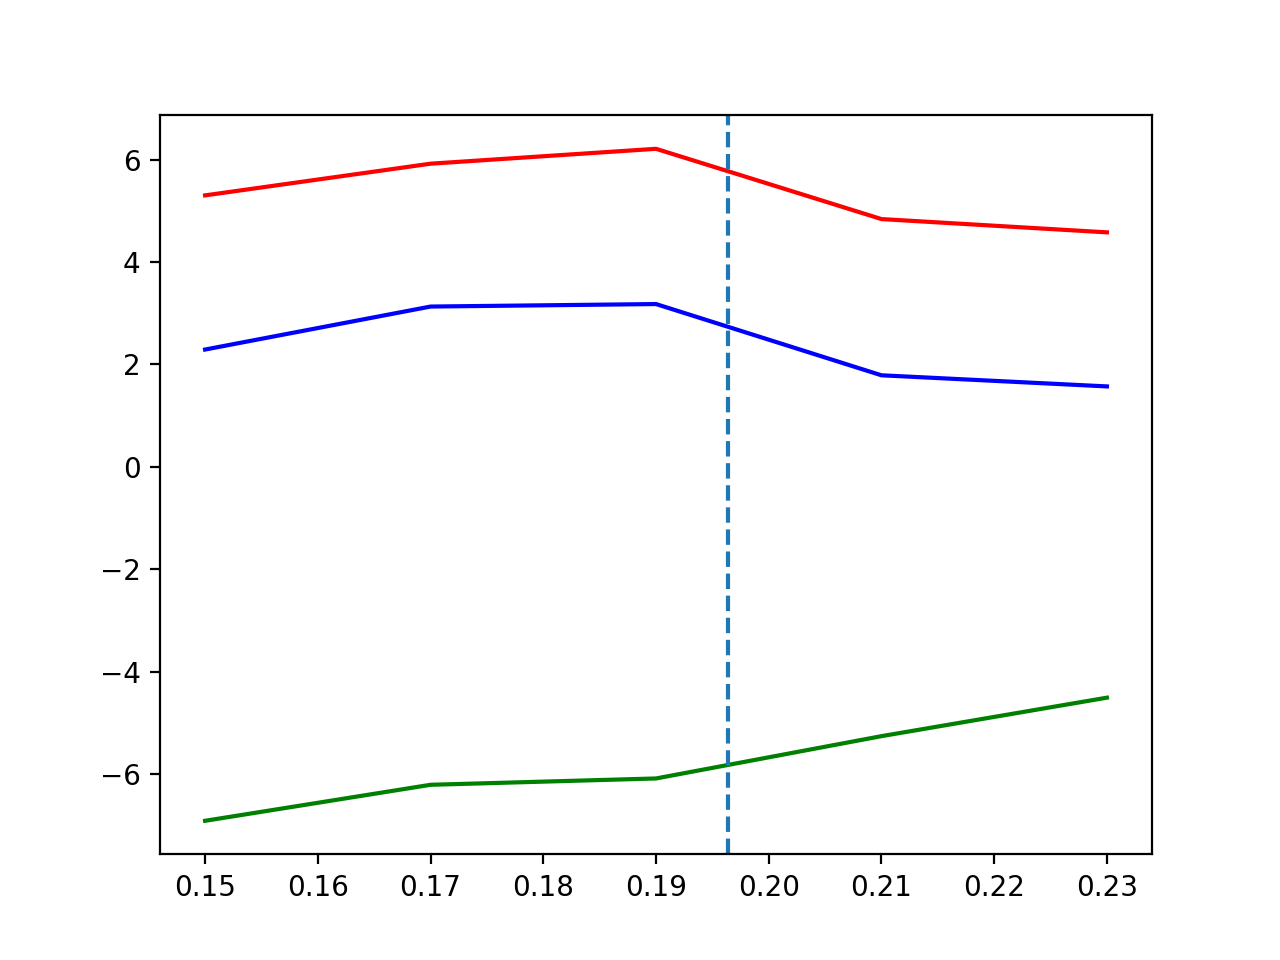

In [79]:
fig3 = plt.figure()
plt.plot(aoa, avg_aoa.max()['eff_coeff'],c='red')
plt.plot(aoa, avg_aoa.min()['eff_coeff'],c='green')
plt.plot(aoa, avg_aoa.apply(lambda x: np.average(x['eff_coeff'],weights=[0.1,0.1,0.4,0.2,0.2])) ,c='blue')
plt.axvline(x=geometry.pi/16.0,ls='--')
fig3.show()
fig3.savefig('eff.png')

This would seem to suggest that folding the wings a little past the fuselage line, rather than the traditional 'dart' fold of $/pi / 16$, is optimal. Not too far though, or the added drag reduces the efficiency. Note however that we're assuming a lot since we don't estimate right on that point. Let's zoom in and add some granularity closer to that critical point:

### Add more sample rows

We may also decide to add more sample points as we look at the results we've generated so far - hopefully we see an interesting area of the design space we'd like to "zoom in" on. We'll add the new sample points as a new dataframe and populate it, then concatenate it with the first and see if we can draw any conclusions from the overall dataset.

In [ ]:

zoomed_params = [geometry.pi/x for x in [15.5, 15.75,16.0,16.25,16.5]]
df2 = pandas.DataFrame(
    [dict(
        chain(
            config.items(),
            {#"project_name": project_name,
                "case_name": f"{config['project_name']}_zoom-{5*i+j:0>3}",
                "fuselage_radians" : zoomed_params[i],
                "angle_of_attack" : 0.0 + 3.0 * j
             }.items()
        )
    ) for i in range(5) for j in range(5)])

df2 = pandas.DataFrame(
    [cfd.single_simulation(
        row, make_airplane_model,
        do_extract=['eff_coeff','lift_coeff', 'drag_coeff', 'momentum_z', 'momentum_x'],
        stdout_to_log=False,
        define_surface_groups=True) 
     for row in df2.to_dict(orient='records')])

ndf = pandas.concat([df,df2],axis=0)

%matplotlib notebook
fig4 = plt.figure()
ax4 = fig4.add_subplot(projection='3d', azim=20)
ax4.scatter3D(ndf['angle_of_attack'], ndf['fuselage_radians'],ndf['eff_coeff'], 
               s=50, alpha=1.0, c=ndf['lift_coeff'],
               cmap='plasma')
ax4.set_xlabel('Angle of Attack')
ax4.set_ylabel('Fuselage Radians')
ax4.set_zlabel('Lift/Drag')

### Integrate out the fold angle instead - find best launch angle

Taking another literal perspective, we can integrate out the design parameter and take a guess that the optimal angle to throw our paper airplane is around $9^{\circ}$

In [ ]:
fig4=plt.figure()
plt.plot(adf.groupby('angle_of_attack').mean()['eff_coeff'])
fig4.show()

# Results

In [ ]:
%matplotlib notebook
plt.scatter(df[['fuselage_rad']], df[['lift']])
plt.show()

### Response Surface

In [ ]:
%matplotlib notebook
from mpl_toolkits import mplot3d
fig = plt.figure(figsize =(10, 10))
ax = plt.axes(projection ='3d')
 
# Creating plot
ax.scatter(df[['angle_of_attack']],df[['fuselage_rad']], df[['lift']])
ax.set_xlabel("Angle of Attack")
ax.set_ylabel("Fuselage Fold Angle")
ax.set_zlabel("Lift")
ax.set_title("Paper Airplane Design Space")
dir(ax)
plt.show()

## Do our CFD results seem reasonable?

## Does our optimization seem reasonable?

## How does clever optimization compare to a grid search?

# Open Questions and Next Steps

* Optimization tools (Dakota, matlab, etc)
* CFD tooling
  * cfd params
  * mesh improvements
  * other CFD platforms
* problem refinement
* more parameter dimensions
* V & V